In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [3]:
dataset_size = len(dataset)
dataset_size

50000

In [4]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [5]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
num_classes = len(classes)
num_classes

10

In [7]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog


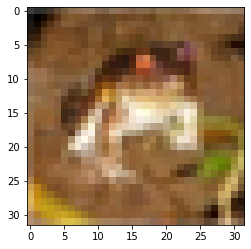

In [8]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [9]:
count = {}
for img, label in dataset:
    name = classes[label]
    if name not in count:
        count[name] = 0
    count[name] = count[name] + 1

count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [10]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [11]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [12]:
batch_size=128

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


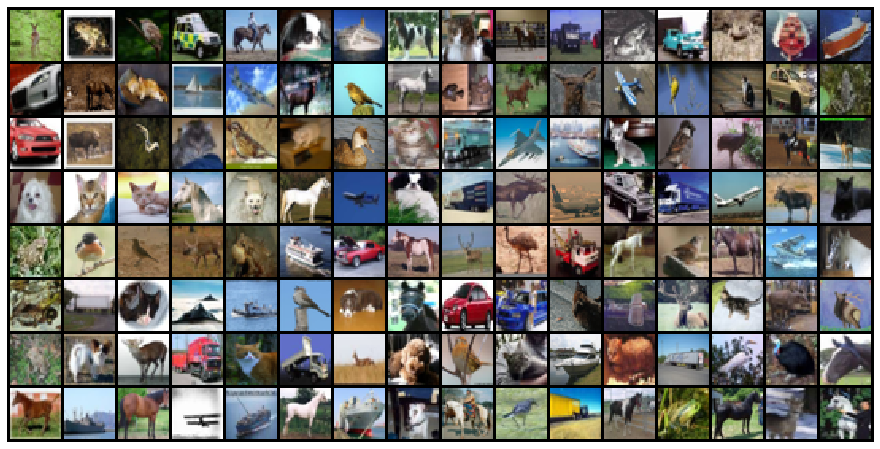

In [14]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
torch.cuda.is_available()

True

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [25]:
input_size = 3*32*32
output_size = 10
hidden_size1 = 2000
hidden_size2 = 1500
hidden_size3 = 1000
hidden_size4 = 500

In [26]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        self.linear5 = nn.Linear(hidden_size4, output_size)

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [27]:
model = to_device(CIFAR10Model(), device)

In [28]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3019120693206787, 'val_acc': 0.1061006411910057}]

In [29]:
history += fit(20, 1e-2, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2914, val_acc: 0.1680
Epoch [1], val_loss: 2.2572, val_acc: 0.1767
Epoch [2], val_loss: 2.1202, val_acc: 0.2036
Epoch [3], val_loss: 2.0387, val_acc: 0.2406
Epoch [4], val_loss: 1.9931, val_acc: 0.2731
Epoch [5], val_loss: 1.9547, val_acc: 0.2765
Epoch [6], val_loss: 1.8997, val_acc: 0.3124
Epoch [7], val_loss: 1.9098, val_acc: 0.3111
Epoch [8], val_loss: 1.8667, val_acc: 0.3286
Epoch [9], val_loss: 1.8128, val_acc: 0.3438
Epoch [10], val_loss: 1.8010, val_acc: 0.3483
Epoch [11], val_loss: 1.7857, val_acc: 0.3574
Epoch [12], val_loss: 1.7453, val_acc: 0.3744
Epoch [13], val_loss: 1.7543, val_acc: 0.3686
Epoch [14], val_loss: 1.8802, val_acc: 0.3340
Epoch [15], val_loss: 1.7371, val_acc: 0.3676
Epoch [16], val_loss: 1.7108, val_acc: 0.3807
Epoch [17], val_loss: 1.6444, val_acc: 0.4102
Epoch [18], val_loss: 1.6600, val_acc: 0.4055
Epoch [19], val_loss: 1.6317, val_acc: 0.4120


In [30]:
history += fit(10, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5840, val_acc: 0.4344
Epoch [1], val_loss: 1.5830, val_acc: 0.4352
Epoch [2], val_loss: 1.5777, val_acc: 0.4363
Epoch [3], val_loss: 1.5768, val_acc: 0.4394
Epoch [4], val_loss: 1.5735, val_acc: 0.4380
Epoch [5], val_loss: 1.5735, val_acc: 0.4400
Epoch [6], val_loss: 1.5685, val_acc: 0.4419
Epoch [7], val_loss: 1.5669, val_acc: 0.4427
Epoch [8], val_loss: 1.5658, val_acc: 0.4415
Epoch [9], val_loss: 1.5622, val_acc: 0.4432


In [31]:
history += fit(10, 1e-5, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5614, val_acc: 0.4430
Epoch [1], val_loss: 1.5612, val_acc: 0.4430
Epoch [2], val_loss: 1.5612, val_acc: 0.4436
Epoch [3], val_loss: 1.5612, val_acc: 0.4438
Epoch [4], val_loss: 1.5611, val_acc: 0.4436
Epoch [5], val_loss: 1.5611, val_acc: 0.4432
Epoch [6], val_loss: 1.5610, val_acc: 0.4439
Epoch [7], val_loss: 1.5610, val_acc: 0.4432
Epoch [8], val_loss: 1.5609, val_acc: 0.4433
Epoch [9], val_loss: 1.5609, val_acc: 0.4430


In [32]:
history += fit(15, 1e-1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9463, val_acc: 0.3008
Epoch [1], val_loss: 1.7370, val_acc: 0.3803
Epoch [2], val_loss: 1.6721, val_acc: 0.4001
Epoch [3], val_loss: 1.6575, val_acc: 0.4006
Epoch [4], val_loss: 1.6698, val_acc: 0.3966
Epoch [5], val_loss: 1.5031, val_acc: 0.4546
Epoch [6], val_loss: 1.4879, val_acc: 0.4619
Epoch [7], val_loss: 1.5060, val_acc: 0.4527
Epoch [8], val_loss: 1.6045, val_acc: 0.4329
Epoch [9], val_loss: 1.5454, val_acc: 0.4589
Epoch [10], val_loss: 1.5835, val_acc: 0.4383
Epoch [11], val_loss: 1.5887, val_acc: 0.4285
Epoch [12], val_loss: 1.4520, val_acc: 0.4786
Epoch [13], val_loss: 1.5312, val_acc: 0.4540
Epoch [14], val_loss: 1.4819, val_acc: 0.4745


In [33]:
history += fit(5, 1e-2, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3191, val_acc: 0.5312
Epoch [1], val_loss: 1.3182, val_acc: 0.5432
Epoch [2], val_loss: 1.3166, val_acc: 0.5434
Epoch [3], val_loss: 1.3191, val_acc: 0.5408
Epoch [4], val_loss: 1.3193, val_acc: 0.5514


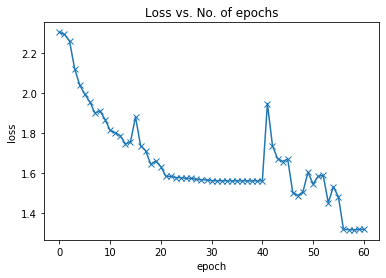

In [34]:
plot_losses(history)

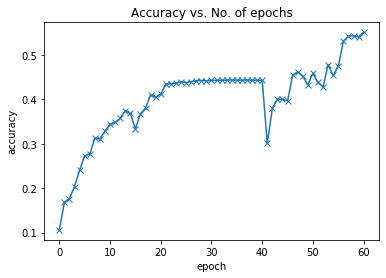

In [35]:
plot_accuracies(history)

In [36]:
evaluate(model, test_loader)

{'val_loss': 1.2658953666687012, 'val_acc': 0.552734375}

In [37]:
arch = "5 layers (2000, 1500, 1000, 500, 10)"

In [38]:
lrs = [1e-2, 1e-3, 1e-5, 1e-1, 1e-2]

In [39]:
epochs = [20, 10, 10, 15, 5]

In [40]:
test_acc = 0.552734375
test_loss = 1.2658953666687012